In [1]:
import glob, os
import shutil
import argparse
import wget

from astropy.time import Time
import numpy as np
from astropy.io import fits
import lightkurve as lk
import matplotlib.pyplot as plt

path = os.path.dirname(os.getcwd())

In [2]:
CH = 1
quarters = np.sort(np.array(os.listdir('%s/data/EXBA/%i/' % (path, CH)), dtype=int))

In [3]:
quarters

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

# Get Qarters star and finish time

In [3]:
quarter_times_edges = {}
for i, q in enumerate(quarters):
    files = np.sort(glob.glob("%s/data/EXBA/%i/%i/*.fits.gz" % (path, CH, q)))

    times = lk.KeplerTargetPixelFile(files[0]).time
    quarter_times_edges[q] = [times.min(), times.max()]

#### from a TPF

In [6]:
tpfs = lk.search_targetpixelfile("Kepler-8",
                                 author="Kepler", 
                                 cadence="long",).download_all()

In [8]:
quarters = np.array([tpf.quarter for tpf in tpfs])
quarters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [12]:
quarter_times_edges = {}
for i, q in enumerate(quarters):
    times = tpfs[q].time
    quarter_times_edges[q] = [times.min(), times.max()]

# Get FFI obs times

In [14]:
ffi_list = np.sort(glob.glob("%s/data/ffi/kplr*_ffi-cal.fits" % (path)))
ffi_time = []
for ffi in ffi_list:
    hdr = fits.open(ffi)[CH].header
    ffi_time.append(Time(hdr['MJDSTART'], format="mjd"))

In [15]:
len(ffi_time), len(ffi_list)

(53, 53)

In [16]:
ffi_time_mjd = np.array([t.mjd for t in ffi_time])

In [18]:
quarter_mjd = [[t[0].jyear, t[1].jyear] for _, t in quarter_times_edges.items()]
ffi_time_mjd = [t.jyear for t in ffi_time]

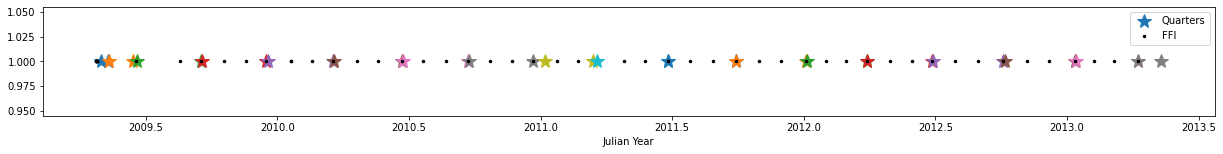

In [59]:
plt.figure(figsize=(21,2))
for i, q in enumerate(quarter_mjd):
    if i == 0:
        plt.plot(q, [1]*len(q), '*', ms=15, label="Quarters")
    else:
        plt.plot(q, [1]*len(q), '*', ms=15)
plt.plot(ffi_time_mjd, [1]*len(ffi_time_mjd), 'k.', ms=5, label="FFI")
#plt.xlim(2010.2, 2013.4)
plt.legend()
plt.xlabel("Julian Year")
plt.show()

### find mapping between ffi and quarters

In [51]:
quarter_times_edges[16][1].jyear

2013.2675146190581

In [49]:
[ffi.jyear for ffi in ffi_time]

[2009.312037306831,
 2009.3123796019713,
 2009.3127933815742,
 2009.313382867132,
 2009.3136681821218,
 2009.3142481363998,
 2009.3147516337303,
 2009.3159365290076,
 2009.4638562413143,
 2009.6325939144149,
 2009.7097470966187,
 2009.7975798076386,
 2009.8821609249555,
 2009.9589765895687,
 2010.0518397238604,
 2010.0520597709515,
 2010.1334580926489,
 2010.2127841980562,
 2010.3025724838878,
 2010.3816775100343,
 2010.4754958615742,
 2010.5531462999043,
 2010.6400835198904,
 2010.7250066908693,
 2010.8098180357015,
 2010.8918321745107,
 2010.9721120458316,
 2011.063807167803,
 2011.1436508387133,
 2011.315329343299,
 2011.3952733435729,
 2011.4823784003834,
 2011.567301753429,
 2011.6556933170157,
 2011.7406724929226,
 2011.8282811719096,
 2011.9130365761532,
 2012.009148580534,
 2012.0846172362492,
 2012.1615402544558,
 2012.2382956463791,
 2012.3285337000411,
 2012.41049169128,
 2012.4875268003832,
 2012.5749676168105,
 2012.6606738615742,
 2012.7565621487747,
 2012.8468561463108,


In [55]:
which_quarter = {}
for i, ffi in enumerate(ffi_time):
    for q, edges in quarter_times_edges.items():
        if ffi.mjd >= edges[0].mjd and ffi.mjd <= edges[1].mjd:
            which_quarter[i] = q
        if q == 0 and ffi.mjd <= edges[1].mjd:
            which_quarter[i] = q
        if q == 17 and ffi.mjd >= edges[0].mjd:
            which_quarter[i] = q
which_quarter[52] = 17

In [56]:
which_quarter

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 9: 2,
 11: 3,
 12: 3,
 14: 4,
 15: 4,
 16: 4,
 18: 5,
 19: 5,
 21: 6,
 22: 6,
 24: 7,
 25: 7,
 27: 8,
 28: 8,
 29: 9,
 30: 9,
 32: 10,
 33: 10,
 35: 11,
 36: 11,
 38: 12,
 39: 12,
 41: 13,
 42: 13,
 44: 14,
 45: 14,
 47: 15,
 48: 15,
 50: 16,
 51: 16,
 52: 17}

In [58]:
for ffi, q in which_quarter.items():
    if not os.path.isdir("%s/data/ffi/%i" % (path, q)):
        os.mkdir("%s/data/ffi/%i" % (path, q))
    
    name = ffi_list[ffi].split('/')[-1]
    out = "%s/data/ffi/%s/%s" % (path, str(q), name)
    print(out)
    try:
        shutil.move(ffi_list[ffi], out)
    except FileNotFoundError:
        continue

/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009114174833_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009114204835_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009115002613_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009115053616_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009115080620_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009115131122_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009115173611_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/0/kplr2009116035924_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/2/kplr2009231194831_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/3/kplr2009292020429_ffi-cal.fits
/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/3/kplr2009322233047_f